## Codebook
<br>

[Ссылка для скачивания данных](https://drive.google.com/open?id=1dPCG76ST6NohYKtVMGv6HpFL-jD5p1eJ)
<br><br>

`telecom_users.csv` содержит следующие значения:<br><br>

&nbsp;&nbsp;&nbsp;&nbsp; `customerID` – id клиента<br>
&nbsp;&nbsp;&nbsp;&nbsp; `gender` – пол клиента (male/female)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `SeniorCitizen` – яляется ли клиент пенсионером (1, 0)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Partner` – состоит ли клиент в браке (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Dependents` – есть ли у клиента иждивенцы (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `tenure` – сколько месяцев человек являлся клиентом компании<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PhoneService` – подключена ли услуга телефонной связи (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MultipleLines` – подключены ли несколько телефонных линий (Yes, No, No phone service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `InternetService` – интернет-провайдер клиента (DSL, Fiber optic, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineSecurity` – подключена ли услуга онлайн-безопасности (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineBackup` – подключена ли услуга online backup (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `DeviceProtection` – есть ли у клиента страховка оборудования (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TechSupport` – подключена ли услуга технической поддержки (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingTV` – подключена ли услуга стримингового телевидения (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingMovies` – подключена ли услуга стримингового кинотеатра (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Contract` – тип контракта клиента (Month-to-month, One year, Two year)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaperlessBilling` – пользуется ли клиент безбумажным биллингом (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaymentMethod` – метод оплаты (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MonthlyCharges` – месячный размер оплаты на настоящий момент<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TotalCharges` – общая сумма, которую клиент заплатил за услуги за все время<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Churn` – произошел ли отток (Yes or No)<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix


In [3]:
VAL_SIZE   = 0.3   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 6000
LR         = 0.05
RANDOM_SEED = 42

In [4]:
df = pd.read_csv('./data/telecom_users.csv')
df = df[df.columns[2:]]
df = df[df['TotalCharges'] != ' ']
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

In [5]:
Y = df['Churn'].copy()

In [6]:
df = df.drop('Churn', axis=1)

In [7]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [9]:
df.select_dtypes(include=['object']).nunique().max()

4

In [10]:
cat_columns = df.select_dtypes(include=['object']).columns
num_columns = df.select_dtypes(include=['number']).columns

In [11]:
df_main = pd.get_dummies(df, prefix=cat_columns)

In [13]:
df_main

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,72,24.10,1734.65,0,1,1,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
1,44,88.15,3973.20,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
2,38,74.95,2869.85,1,0,0,1,0,1,1,...,0,1,0,0,0,1,1,0,0,0
3,4,55.90,238.50,0,1,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0
4,2,53.45,119.50,0,1,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,1,95.00,95.00,0,1,1,0,0,1,1,...,1,1,0,0,0,1,0,0,1,0
5982,23,91.10,2198.30,1,0,1,0,0,1,0,...,1,0,0,1,0,1,0,1,0,0
5983,12,21.15,306.05,0,1,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
5984,12,99.45,1200.15,0,1,0,1,1,0,1,...,1,1,0,0,0,1,0,0,1,0


In [14]:
sc = StandardScaler()

In [15]:
df_main[num_columns] = sc.fit_transform(df[num_columns])

In [16]:
df_main.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.611381,-1.353483,-0.247769,0,1,1,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
1,0.468468,0.774066,0.736669,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
2,0.223558,0.335602,0.251453,1,0,0,1,0,1,1,...,0,1,0,0,0,1,1,0,0,0
3,-1.164265,-0.297182,-0.905725,0,1,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0
4,-1.245901,-0.378564,-0.958057,0,1,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0


In [17]:
df_main.columns = map(lambda x: x.lower(), df_main.columns)

In [18]:
Y.value_counts(normalize=True)

0    0.734438
1    0.265562
Name: Churn, dtype: float64

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df_main, Y, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=Y, shuffle=True)

In [22]:
LogisticRegression?

In [23]:
log_reg = LogisticRegression(random_state=RANDOM_SEED, penalty='l1', solver='liblinear')

In [24]:
log_reg.fit(x_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [25]:
def eval_model(model, x_test, y_test):
    print('Accurace score: {}'.format(accuracy_score(
        y_test, model.predict(x_test)
    )))
    print('Точность: {}'.format(precision_score(y_test, model.predict(x_test))))
    print('Полнота: {}'.format(recall_score(y_test, model.predict(x_test))))
    print('F1 Score: {}'.format(f1_score(y_test, model.predict(x_test))))
    print('Roc_Auc Score: {}'.format(roc_auc_score(y_test, model.predict(x_test))))
    plot_confusion_matrix(model, x_test, y_test)
    plot_roc_curve(model, x_test, y_test)
    plt.show()

Accurace score: 0.8014500836586727
Точность: 0.6515151515151515
Полнота: 0.542016806722689
F1 Score: 0.5917431192660549
Roc_Auc Score: 0.7186166038169254


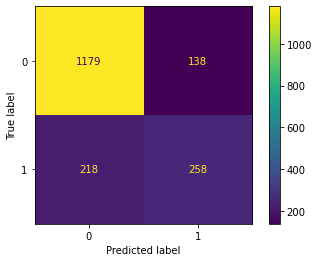

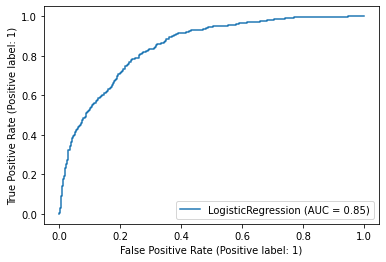

In [27]:
eval_model(log_reg, x_test, y_test)

In [28]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)

Accurace score: 0.7306190741773564
Точность: 0.49272349272349275
Полнота: 0.49789915966386555
F1 Score: 0.49529780564263326
Roc_Auc Score: 0.6563148038258584


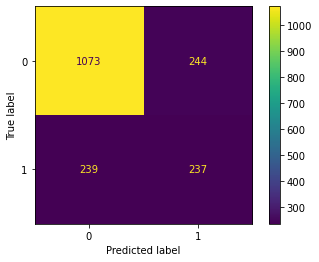

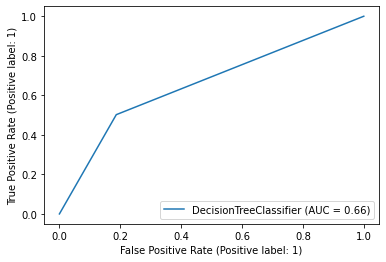

In [29]:
eval_model(dtc, x_test, y_test)

Accurace score: 0.788622420524261
Точность: 0.6405797101449275
Полнота: 0.4642857142857143
F1 Score: 0.53836784409257
Roc_Auc Score: 0.6850661676971472


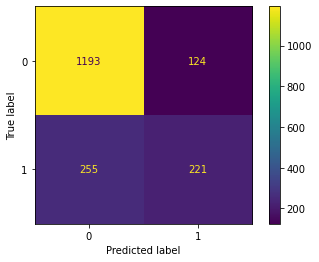

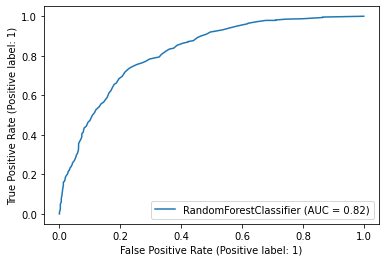

In [30]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train, y_train)
eval_model(rfc, x_test, y_test)

In [31]:
cbc = CatBoostClassifier(iterations=ITERATIONS,
                         learning_rate=LR,
                         random_seed=RANDOM_SEED,
                         eval_metric='AUC',
                         #custom_metric=['Precision'],
                         task_type='CPU',
                         bagging_temperature=5,
                         random_strength=3)

In [32]:
df[num_columns] = sc.fit_transform(df[num_columns])

In [33]:
cat_features_ids = np.where(df.apply(pd.Series.nunique) < 5)[0].tolist()

In [34]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED, stratify=Y)

In [35]:
cbc.fit(x_train, y_train,
          cat_features=cat_features_ids,
          eval_set=(x_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8150279	best: 0.8150279 (0)	total: 74.2ms	remaining: 7m 25s
100:	test: 0.8485728	best: 0.8485824 (98)	total: 420ms	remaining: 24.5s
200:	test: 0.8511211	best: 0.8514162 (192)	total: 766ms	remaining: 22.1s
300:	test: 0.8521276	best: 0.8528853 (253)	total: 1.21s	remaining: 22.8s
400:	test: 0.8508108	best: 0.8528853 (253)	total: 1.65s	remaining: 23.1s
500:	test: 0.8488129	best: 0.8528853 (253)	total: 2.1s	remaining: 23.1s
600:	test: 0.8455882	best: 0.8528853 (253)	total: 2.55s	remaining: 22.9s
700:	test: 0.8432417	best: 0.8528853 (253)	total: 3.07s	remaining: 23.2s
800:	test: 0.8406608	best: 0.8528853 (253)	total: 3.53s	remaining: 22.9s
900:	test: 0.8401088	best: 0.8528853 (253)	total: 3.99s	remaining: 22.6s
1000:	test: 0.8391613	best: 0.8528853 (253)	total: 4.47s	remaining: 22.3s
1100:	test: 0.8380782	best: 0.8528853 (253)	total: 4.93s	remaining: 21.9s
1200:	test: 0.8369376	best: 0.8528853 (253)	total: 5.41s	remaining: 21.6s
1300:	test: 0.8350856	best: 0.8528853 (253)	total: 5

In [275]:
cbc.save_model('./cbc_model.model')

Accurace score: 0.807585052983826
Точность: 0.6692506459948321
Полнота: 0.5441176470588235
F1 Score: 0.6002317497103128
Roc_Auc Score: 0.7234635311983563


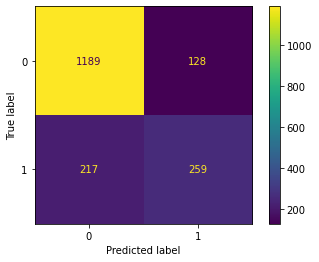

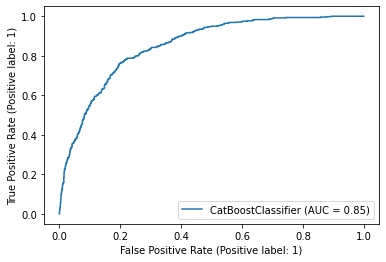

In [36]:
eval_model(cbc, x_test, y_test)

In [341]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1525
TotalCharges        5610
dtype: int64

In [334]:
cbc.feature_importances_

array([ 1.52316265,  1.05876446,  0.6422907 ,  0.19047737, 13.82794992,
        0.07619599,  4.61511622,  7.66562981,  9.04713379,  3.94418506,
        2.4089303 ,  3.63879447,  2.4601331 ,  4.09331716, 20.37791782,
        2.74913941,  5.94842747,  7.4571315 ,  8.27530278])